<a href="https://colab.research.google.com/github/jgamblin/CVEStats/blob/main/CVEStats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CVE Stats Notebook

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic data analysis.  

## Getting Started

### Retrieve The Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2020}.json.zip 
!unzip -o "*.zip" 

(Note: The Output of this cell is hidden with `%%capture`)

### Import Python Libraries 

In [2]:
import glob
import json
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import re
import uuid
from datetime import datetime

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [3]:
row_accumulator = []
for filename in glob.glob('*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
print ('CVEs from NVD:', nvd['CVE'].count())
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
per_day = nvdcount/nvdunique
per_day = round(per_day, 0)
print('CVEs Published Per Publishing Day:', per_day)

CVEs from NVD: 146450
CVEs Published Per Publishing Day: 24.0


(Note: The code for building this dataframe is based off the great work in this [repo](https://github.com/joocer/mitre-tools/blob/74a08bca9e79f2c18cc4e8671d1d7da5b43a2dd4/source/data/02%20process_rawdata.py))

### CVEs Per Day Graph

Text(0.5, 0, 'Date')

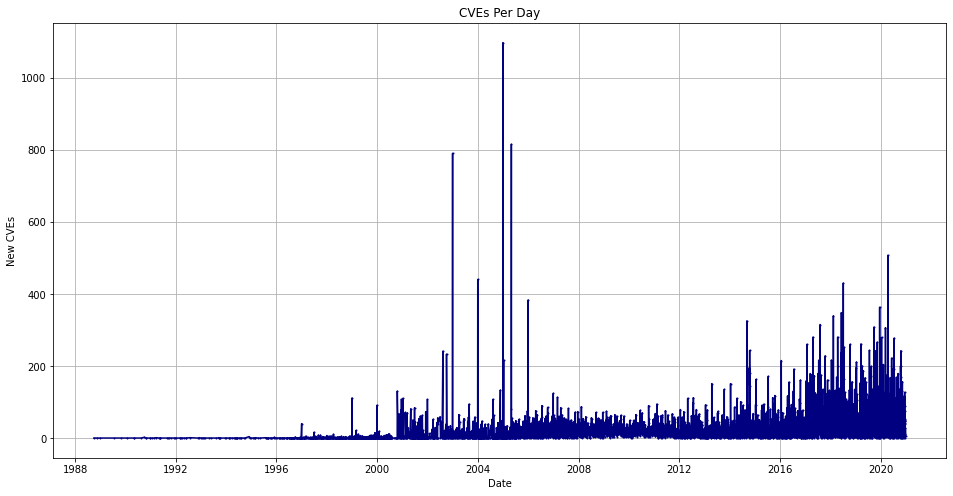

In [4]:
nvd_data = nvd['Published'].value_counts()
cg = nvd_data.plot(colormap='jet', marker='.', figsize=(16, 8), markersize=2, title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs")
cg.set_xlabel("Date")

### Most CVEs Per Day 

In [5]:
nvd['Published'].value_counts().head(10)

2004-12-31    1098
2005-05-02     816
2002-12-31     791
2020-04-15     508
2003-12-31     441
2018-07-09     431
2005-12-31     384
2019-12-18     364
2018-06-11     349
2018-02-15     340
Name: Published, dtype: int64

## Data Clean Up

The NVD dataset is notoriously incomplete, and I wanted to clean it up as much as possible.

###  Missing Data Points

To see how much data was missing, I use a tool called [MissingNo](https://github.com/ResidentMario/missingno) to get a visualization. 

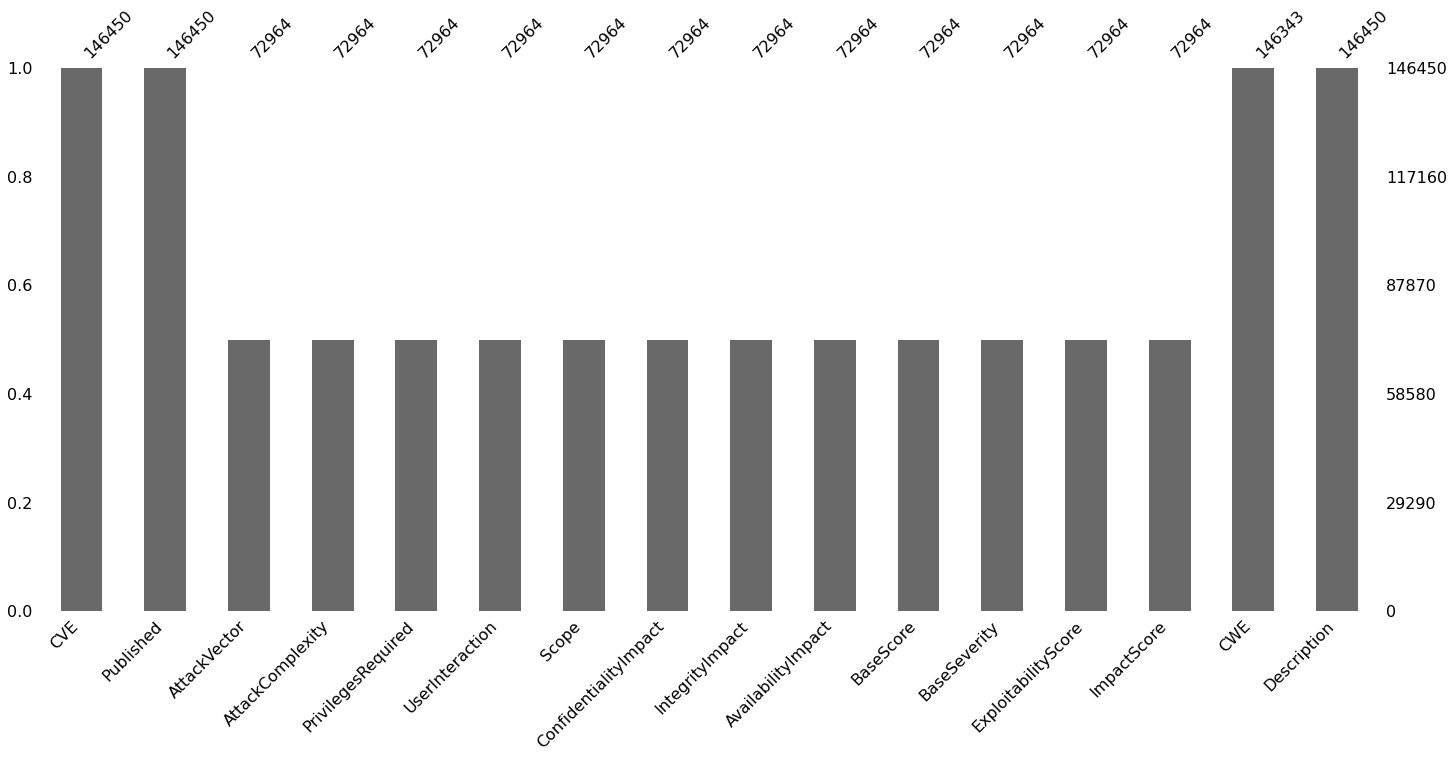

In [6]:
nvd = nvd.replace("Missing_Data_JG", np.nan)
msno.bar(nvd)

### Drop CVEs Without CVSS Score

It appears over half of the dataset is missing ~12 data points.  I am going to drop all rows that do not contain a CVSS `BaseScore` for simpicity. 

In [7]:
nvd = nvd[nvd['BaseScore'].notna()]
print ('CVEs With Complete Data:', nvd['CVE'].count())

CVEs With Complete Data: 72964


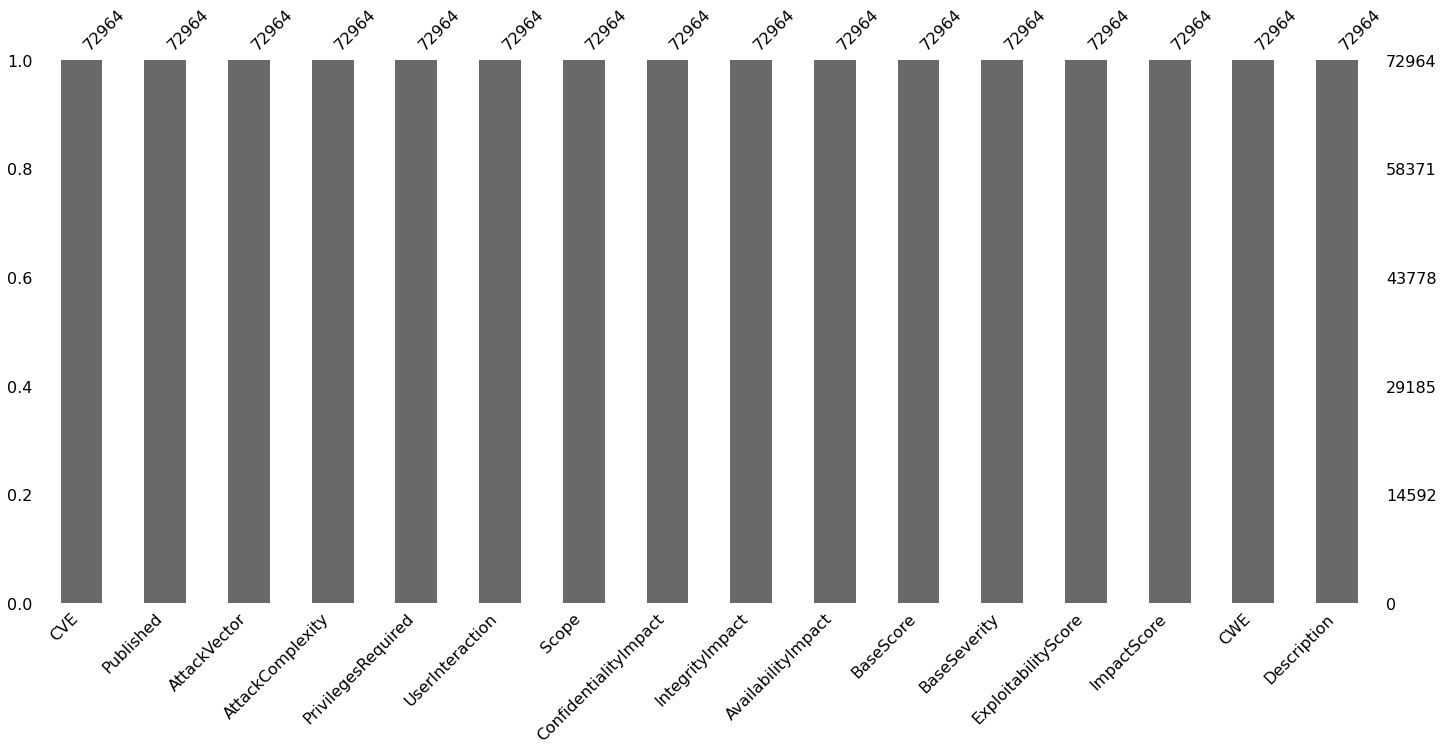

In [8]:
msno.bar(nvd)

In [9]:
print ('CVEs from NVD:', nvd['CVE'].count())
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
per_day = nvdcount/nvdunique
per_day = round(per_day, 0)
print('CVEs Published Per Publishing Day:', per_day)

CVEs from NVD: 72964
CVEs Published Per Publishing Day: 42.0


### CVEs Per Day Graph (All Data Points)

Text(0.5, 0, 'Date')

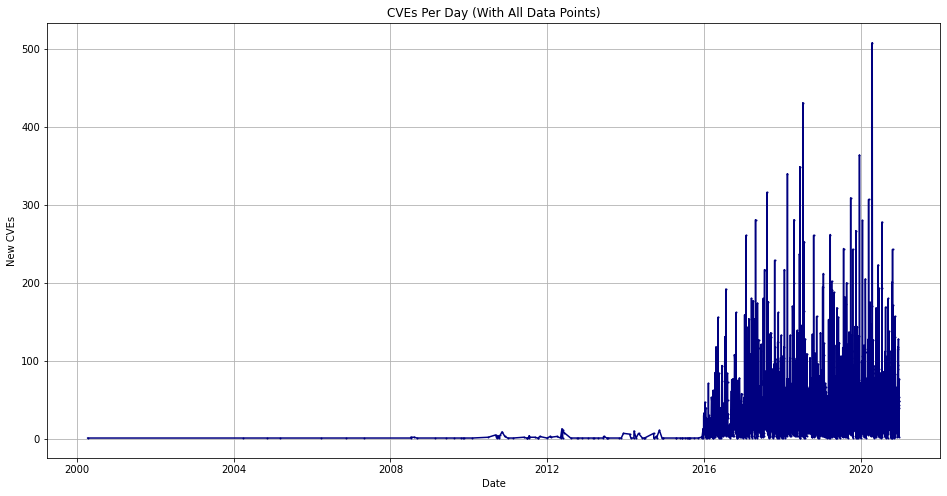

In [10]:
nvd_data = nvd['Published'].value_counts()
cg = nvd_data.plot(colormap='jet', marker='.', figsize=(16, 8), markersize=2, title='CVEs Per Day (With All Data Points)')
plt.grid()
cg.set_ylabel("New CVEs")
cg.set_xlabel("Date")

### Most CVEs Per Day 

In [11]:
nvd['Published'].value_counts().head(10)

2020-04-15    508
2018-07-09    431
2019-12-18    364
2018-06-11    349
2018-02-15    340
2017-08-08    316
2019-09-27    309
2020-03-12    307
2018-04-18    281
2017-04-24    281
Name: Published, dtype: int64